In [22]:
import pandas as pd
import datetime as date
import time
import numpy as np
import plotly.express as px
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from numpy import array
from keras.models import load_model

# Funções

In [23]:
def avaliacao(df_aux, col_pred, col_real):    
    df = df_aux.copy()
    df['PE'] = abs(df[col_pred]-df[col_real])/df[col_real]
    df['AE'] = abs(df[col_pred]-df[col_real])
    df['SE'] = (df[col_pred]-df[col_real])*(df[col_pred]-df[col_real])
    mae = df['AE'].mean()
    mape = df['PE'].mean()
    rmse = sqrt(float(df['SE'].mean()))
    #print('MAE: ',mae)
    #print('MAPE: ',mape)
    #print('RMSE: ',rmse)
    return mae, mape, rmse, df

In [24]:
def inverse_MinMax(df, df_inverse, col_pred, col_inverse):
    df_aux = df.copy()
    df_aux[col_pred] = (df_aux[col_pred]*df_inverse[col_inverse][1])+df_inverse[col_inverse][0]
    return df_aux

In [25]:
def pred_for_inverse(pred, X, Y):
    array_aux = [[0]]*Y.shape[1]
    c=0
    for i in pred[0]:
        a = [0]*X.shape[2]
        a[0] = i
        array_aux[c] = a
        c+=1
    return array_aux

In [26]:
def teste_modelo_3feat (modelo, TrainX, TrainY, TestX, TestY, scaler_used, df_original):
    dict_global = {} 
    for i in range(0,testX.shape[0]):
        x_input = array(TestX[i].reshape((1, TestX.shape[1], TestX.shape[2])))
        prediction = modelo.predict(x_input)
        predction_for_inv = pred_for_inverse(prediction, TrainX, TrainY)
        Pred_inversed = scaler_used.inverse_transform(predction_for_inv)
        pred_inverse = pd.DataFrame()
        pred_inverse = pd.DataFrame(Pred_inversed)
        pred_inverse = pred_inverse.rename(columns={0:'PLD - Predito'}).drop(columns={1,2})
        pred_inverse = pred_inverse.set_index(df_original[TestX.shape[1]+i:TestX.shape[1]+TestY.shape[1]+i].index)
        df_comp = pred_inverse.join(df_original['SE - PLD Médio (R$/MWh)'][TestX.shape[1]+i:TestX.shape[1]+TestY.shape[1]+i])
        col_pred, col_real = df_comp.columns[0], df_comp.columns[1]
        aval = avaliacao(df_comp, col_pred, col_real)
        dict_info = {'mae':aval[0], 'mape':aval[1], 'rmse':aval[2]}
        dict_append = {'df':aval[3], 'info':dict_info }
        dict_global[i+1] = dict_append
    return dict_global

In [27]:
def Janelamento_Sem_Saturação(list_df, n_lags, n_steps):
    array_aux_X_final = []
    array_aux_Y_final = []
    for i in list_df:
        array_aux_train_1 = []
        array_aux_test_1 = []
        trainX = []
        trainY = []
        df_for_training_scaled = np.array(i)
        df_for_testing_scaled = np.array(i)
        for i in range(n_lags, len(df_for_training_scaled) - n_steps +1):
            trainX.append(df_for_training_scaled[i - n_lags:i, 0:df_for_training_scaled.shape[1]])
            trainY.append(df_for_training_scaled[i : i + n_steps, 0])
        trainX, trainY = np.array(trainX), np.array(trainY)
        if array_aux_X_final == array_aux_Y_final:
            array_aux_X_final = trainX
            array_aux_Y_final = trainY
        else:
            array_aux_X_final = np.append(array_aux_X_final, trainX, axis=0)
            array_aux_Y_final = np.append(array_aux_Y_final, trainY, axis=0)
    return array_aux_X_final, array_aux_Y_final

________________________________________________________________________________________________________________________

# Leitura dos dados

## PLD

In [28]:
df_final_PLD =  pd.read_excel(r'C:\Users\pablo\OneDrive\Documents\AAA_TCC\Dados Tratados\PLD_2018_2021_diario.xlsx')

In [29]:
df_final_PLD_2 = df_final_PLD.copy()
df_final_PLD_2['Data'] = pd.to_datetime(df_final_PLD_2['Data'])
df_final_PLD_2 = df_final_PLD_2.set_index('Data')

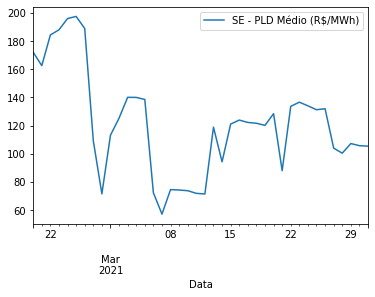

In [30]:
datainicio,datafim = '2021-02-20','2021-03-31'
df_final_PLD_plot = df_final_PLD_2
df_final_PLD_plot['Data'] = pd.to_datetime(df_final_PLD_2.index)
df_final_PLD_plot = df_final_PLD_plot.loc[datainicio:datafim]
PLDSE = df_final_PLD_plot.plot(x = 'Data', y='SE - PLD Médio (R$/MWh)', kind = 'line')
#PLDSE.get_figure().savefig(r'C:\Users\pablo\OneDrive\Pictures\AAA TCC\Plots_Iniciais\PLD_SE')

________________________________________________________________________________________________________________________

## ENA por Subsistema

In [31]:
df_final_ENASub = pd.read_excel(r'C:\Users\pablo\OneDrive\Documents\AAA_TCC\Dados Tratados\ENA_Sub_2018_2021_diario.xlsx', index_col = 'Data')
df_ENA_total = pd.read_excel(r'C:\Users\pablo\OneDrive\Documents\AAA_TCC\Dados Tratados\ENA_Total_2018_2021_diario.xlsx', index_col = 'Data')

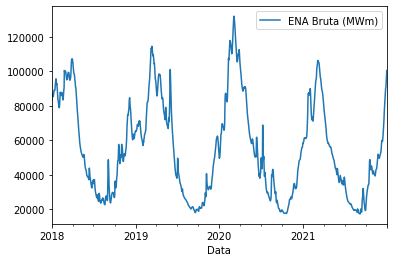

In [32]:
datainicio,datafim = '2018-01-01','2021-12-31'
df_ENA_total_plot = df_ENA_total
df_ENA_total_plot['Data'] = df_ENA_total.index
df_ENA_total_plot = df_ENA_total_plot.loc[datainicio:datafim]
df_ENA_total = df_ENA_total.drop(columns=['Data'])
ENAPLOT = df_ENA_total_plot.plot(x = 'Data', y='ENA Bruta (MWm)', kind = 'line')
#ENAPLOT.get_figure().savefig(r'C:\Users\pablo\OneDrive\Pictures\AAA TCC\Plots_Iniciais\ENA')

In [33]:
df_ecolhido_ena = df_ENA_total.drop(columns = 'ENA Armaz. (MWm)')


________________________________________________________________________________________________________________________

##  EAR por Subsistema

In [34]:
df_final_EARSub = pd.read_excel(r'C:\Users\pablo\OneDrive\Documents\AAA_TCC\Dados Tratados\EAR_Sub_2018_2021_diario.xlsx', index_col = 'Data')
df_EAR_total = pd.read_excel(r'C:\Users\pablo\OneDrive\Documents\AAA_TCC\Dados Tratados\EAR_Total_2018_2021_diario.xlsx', index_col = 'Data')

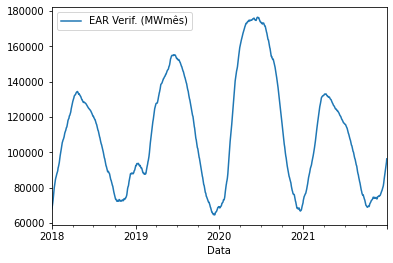

In [35]:
datainicio,datafim = '2018-01-01','2021-12-31'
df_EAR_total_plot = df_EAR_total
df_EAR_total_plot['Data'] = df_EAR_total.index
df_EAR_total_plot = df_EAR_total_plot.loc[datainicio:datafim]
EARPLOT = df_EAR_total_plot.plot(x = 'Data', y='EAR Verif. (MWmês)', kind = 'line')
df_EAR_total = df_EAR_total.drop(columns=['Data'])
#EARPLOT.get_figure().savefig(r'C:\Users\pablo\OneDrive\Pictures\AAA TCC\Plots_Iniciais\teste')

________________________________________________________________________________________________________________________

## Carga diária Energia

In [36]:
df_final_Carga = pd.read_excel(r'C:\Users\pablo\OneDrive\Documents\AAA_TCC\Dados Tratados\Carga_Sub_2018_2021_diario.xlsx', index_col = 'Data')
df_Carga_total = pd.read_excel(r'C:\Users\pablo\OneDrive\Documents\AAA_TCC\Dados Tratados\Carga_Total_2018_2021_diario.xlsx', index_col = 'Data')

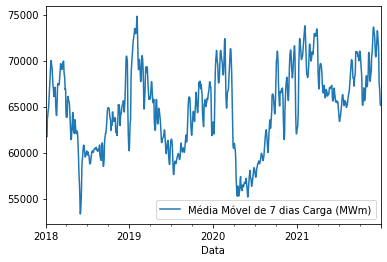

In [37]:
datainicio,datafim = '2018-01-01','2021-12-31'
df_Carga_total_plot = df_Carga_total
df_Carga_total_plot['Data'] = df_Carga_total.index
df_Carga_total_plot = df_Carga_total_plot.loc[datainicio:datafim]
df_Carga_total_plot = df_Carga_total_plot.rename(columns={'Media Móvel 7':'Média Móvel de 7 dias Carga (MWm)'})
df_Carga_total = df_Carga_total.drop(columns=['Data'])
CARGAPLOT = df_Carga_total_plot.plot(x = 'Data', y='Média Móvel de 7 dias Carga (MWm)', kind = 'line')
#CARGAPLOT.get_figure().savefig(r'C:\Users\pablo\OneDrive\Pictures\AAA TCC\it_novembro\Carga_mediamovel')

________________________________________________________________________________________________________________________

# Junção Variáveis

In [43]:
def JoinVar (df1, df2, df3, df4, df5, df6, df7):
    lista = [df2, df3, df4, df5, df6, df7]
    df_final = df1
    for i in lista:
        df_final = df_final.join(i)
    return df_final

In [39]:
def MinMax_Scaler(df):
    df_aux = df.copy()
    df_inverse = pd.DataFrame()
    for i in df.columns:
        df_inverse[i] = [df[i].min(), (df[i].max() - df[i].min())]
        df_aux[i] = (df[i] - df[i].min())/(df[i].max() - df[i].min()) 
    return df_aux, df_inverse

In [40]:
def Inverse_MinMax_Scaler(df, df_inverse):
    df_aux = df.copy()
    for i in df.columns:
        df_aux[i] = (df_aux[i]*df_inverse[i][1])+df_inverse[i][0]
    return df_aux

In [44]:
df_var = JoinVar (df_final_PLD_2, df_final_ENASub, df_final_EARSub, df_final_Carga, df_Carga_total, df_ENA_total, df_EAR_total)
df_var.columns

Index(['SE - PLD Médio (R$/MWh)', 'S - PLD Médio (R$/MWh)',
       'NE - PLD Médio (R$/MWh)', 'N - PLD Médio (R$/MWh)', 'Data',
       'SE - ENA Bruta (MWm)', 'SE - ENA Bruta (%)',
       'SE - ENA Bruta Armaz. (MWm)', 'SE - ENA Armaz. (%)',
       'S - ENA Bruta (MWm)', 'S - ENA Bruta (%)',
       'S - ENA Bruta Armaz. (MWm)', 'S - ENA Armaz. (%)',
       'NE - ENA Bruta (MWm)', 'NE - ENA Bruta (%)',
       'NE - ENA Bruta Armaz. (MWm)', 'NE - ENA Armaz. (%)',
       'N - ENA Bruta (MWm)', 'N - ENA Bruta (%)',
       'N - ENA Bruta Armaz. (MWm)', 'N - ENA Armaz. (%)', 'SE - EAR Máx.',
       'SE - EAR Verif. (MWmês)', 'SE - EAR Verif (%)', 'S - EAR Máx.',
       'S - EAR Verif. (MWmês)', 'S - EAR Verif (%)', 'NE - EAR Máx.',
       'NE - EAR Verif. (MWmês)', 'NE - EAR Verif (%)', 'N - EAR Máx.',
       'N - EAR Verif. (MWmês)', 'N - EAR Verif (%)', 'SE - Carga (MWm)',
       'S - Carga (MWm)', 'NE - Carga (MWm)', 'N - Carga (MWm)', 'Carga (MWm)',
       'Media Móvel 7', 'ENA Bruta (MW

In [45]:
df_corr = df_var.corr()
df_corr.style.background_gradient(cmap='coolwarm')

,SE - PLD Médio (R$/MWh),S - PLD Médio (R$/MWh),NE - PLD Médio (R$/MWh),N - PLD Médio (R$/MWh),SE - ENA Bruta (MWm),SE - ENA Bruta (%),SE - ENA Bruta Armaz. (MWm),SE - ENA Armaz. (%),S - ENA Bruta (MWm),S - ENA Bruta (%),S - ENA Bruta Armaz. (MWm),S - ENA Armaz. (%),NE - ENA Bruta (MWm),NE - ENA Bruta (%),NE - ENA Bruta Armaz. (MWm),NE - ENA Armaz. (%),N - ENA Bruta (MWm),N - ENA Bruta (%),N - ENA Bruta Armaz. (MWm),N - ENA Armaz. (%),SE - EAR Máx.,SE - EAR Verif. (MWmês),SE - EAR Verif (%),S - EAR Máx.,S - EAR Verif. (MWmês),S - EAR Verif (%),NE - EAR Máx.,NE - EAR Verif. (MWmês),NE - EAR Verif (%),N - EAR Máx.,N - EAR Verif. (MWmês),N - EAR Verif (%),SE - Carga (MWm),S - Carga (MWm),NE - Carga (MWm),N - Carga (MWm),Carga (MWm),Media Móvel 7,ENA Bruta (MWm),ENA Armaz. (MWm),EAR Máx.,EAR Verif. (MWmês),EAR Verif. Total (%)
SE - PLD Médio (R$/MWh),1.000000,0.994705,0.909312,0.884002,-0.456428,-0.491654,-0.464533,-0.455538,-0.059174,-0.114586,-0.041597,-0.101654,-0.500729,-0.530166,-0.501979,-0.541761,-0.479774,-0.432363,-0.478584,-0.329629,-0.029409,-0.449146,-0.447201,-0.289713,-0.180718,-0.173470,0.165258,-0.442120,-0.447985,0.076971,-0.096069,-0.098508,0.121529,0.082629,0.194463,0.225818,0.137828,0.112206,-0.519506,-0.512795,-0.001605,-0.462456,-0.461686
S - PLD Médio (R$/MWh),0.994705,1.000000,0.904744,0.878021,-0.430855,-0.480984,-0.439090,-0.447259,-0.073684,-0.128961,-0.057313,-0.117043,-0.470710,-0.513586,-0.471630,-0.524715,-0.454323,-0.425578,-0.454286,-0.330139,-0.026933,-0.437859,-0.435999,-0.280746,-0.201202,-0.193973,0.161269,-0.433345,-0.439084,0.071452,-0.091458,-0.093843,0.131827,0.098106,0.198766,0.221881,0.148357,0.125605,-0.494213,-0.488340,-0.000326,-0.453898,-0.453173
NE - PLD Médio (R$/MWh),0.909312,0.904744,1.000000,0.904331,-0.446987,-0.389409,-0.442921,-0.334980,-0.010383,-0.082901,0.008350,-0.071058,-0.477974,-0.494069,-0.479859,-0.506747,-0.513141,-0.422301,-0.521066,-0.320421,0.031212,-0.440932,-0.439546,-0.273832,-0.125596,-0.119064,0.213875,-0.449425,-0.456487,0.136314,-0.059133,-0.061980,0.072301,0.038958,0.199103,0.239989,0.098127,0.065714,-0.511988,-0.497719,0.059536,-0.449012,-0.448995
N - PLD Médio (R$/MWh),0.884002,0.878021,0.904331,1.000000,-0.578325,-0.445260,-0.567771,-0.372311,-0.063593,-0.165849,-0.056603,-0.167840,-0.507864,-0.393938,-0.511248,-0.407100,-0.614781,-0.383116,-0.634752,-0.260287,0.110757,-0.456550,-0.455916,-0.207597,-0.154471,-0.149019,0.221227,-0.393223,-0.400198,0.148828,-0.074835,-0.077828,0.020138,0.008442,0.137309,0.273484,0.051660,0.004417,-0.642517,-0.627355,0.123416,-0.449669,-0.450455
SE - ENA Bruta (MWm),-0.456428,-0.430855,-0.446987,-0.578325,1.000000,0.545385,0.996080,0.445929,-0.041514,0.129469,-0.036907,0.151537,0.827614,0.379964,0.834219,0.389409,0.719921,0.182807,0.790982,0.072333,-0.015887,0.085437,0.085042,0.083652,-0.169024,-0.167653,-0.082695,0.041745,0.043551,-0.048080,-0.243900,-0.243389,0.225822,0.277389,0.164607,-0.280284,0.213207,0.306996,0.960672,0.975901,-0.028753,0.028385,0.028477
SE - ENA Bruta (%),-0.491654,-0.480984,-0.389409,-0.445260,0.545385,1.000000,0.563227,0.985026,0.223128,0.212427,0.216540,0.203224,0.367431,0.463248,0.364735,0.459035,0.236147,0.334338,0.263015,0.312438,-0.278758,0.154029,0.156349,-0.058174,0.205912,0.208398,-0.278644,-0.139934,-0.132083,-0.215637,-0.100238,-0.097266,-0.140486,-0.041888,-0.043788,-0.296624,-0.123014,-0.166852,0.511125,0.531945,-0.295680,0.082649,0.086538
SE - ENA Bruta Armaz. (MWm),-0.464533,-0.439090,-0.442921,-0.567771,0.996080,0.563227,1.000000,0.475985,-0.030418,0.137768,-0.024186,0.160785,0.822780,0.388107,0.829853,0.398334,0.687344,0.174775,0.762699,0.076583,-0.010810,0.068965,0.068597,0.085495,-0.169470,-0.168041,-0.088607,0.025838,0.027866,-0.049880,-0.270550,-0.270018,0.227797,0.285328,0.171368,-0.279114,0.217398,0.300525,0.949056,0.972470,-0.027487,0.009815,0.009959
SE - ENA Armaz. (%),-0.455538,-0.447259,-0.334980,-0.372311,0.445929,0.985026,0.475985,1.000000,0.247359,0.214034,0.245548,0.2

________________________________________________________________________________________________________________________

# Escolha Variáveis

In [46]:
sel = ['S - PLD Médio (R$/MWh)', 'NE - PLD Médio (R$/MWh)',
       'N - PLD Médio (R$/MWh)','SE - ENA Bruta (%)','SE - ENA Armaz. (%)','SE - EAR Verif (%)',
     'Carga (MWm)','Media Móvel 7', 'ENA Bruta (MWm)','ENA Armaz. (MWm)','EAR Verif. Total (%)']
df_escolhido = pd.DataFrame( {'SE - PLD Médio (R$/MWh)':df_var['SE - PLD Médio (R$/MWh)']})
for i in sel:
    df_escolhido = df_escolhido.join(df_var[i])
df_escolhido

,SE - PLD Médio (R$/MWh),S - PLD Médio (R$/MWh),NE - PLD Médio (R$/MWh),N - PLD Médio (R$/MWh),SE - ENA Bruta (%),SE - ENA Armaz. (%),SE - EAR Verif (%),Carga (MWm),Media Móvel 7,ENA Bruta (MWm),ENA Armaz. (MWm),EAR Verif. Total (%)
Data,,,,,,,,,,,,
2018-05-02,214.646667,214.662500,190.621250,178.925000,88.275002,76.983398,43.900200,65381.392583,62470.348417,58970.907959,49664.467773,0.458910
2018-05-03,168.905833,168.934167,120.433333,120.406667,86.215599,78.004204,43.828999,66938.248333,62346.022095,57479.126953,49444.537354,0.457995
2018-05-04,225.345833,225.367500,114.855000,114.823333,84.744102,77.204201,43.728298,67031.116625,62219.178869,56654.833008,48306.832764,0.456794
2018-05-05,275.532500,275.570833,123.934583,123.894583,83.725899,75.946098,43.696999,61356.033375,62134.300214,55804.570068,46507.023682,0.456325
2018-05-06,155.334583,155.357917,77.849167,77.827500,82.473701,71.800201,43.691299,55092.441625,62080.463613,54926.362549,44621.667969,0.456129
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,68.084167,68.085000,68.037917,68.037083,110.278900,96.091698,24.684700,69066.145500,66970.400155,90544.118652,79667.989746,0.314215
2021-12-28,68.389167,68.389167,68.353333,68.352500,110.417297,96.244102,24.862000,69954.770708,66429.492506,91952.735107,80709.130127,0.317530
2021-12-29,66.705417,66.705417,66.067500,65.970833,111.535103,96.548798,25.012400,69973.731792,65782.750810,94431.855835,82476.878052,0.320648


In [47]:
sel_2 = ['ENA Bruta (MWm)','EAR Verif. (MWmês)','Carga (MWm)']
df_4_features = pd.DataFrame( {'SE - PLD Médio (R$/MWh)':df_var['SE - PLD Médio (R$/MWh)']})
for i in sel_2:
    df_4_features = df_4_features.join(df_var[i])
df_4_features

,SE - PLD Médio (R$/MWh),ENA Bruta (MWm),EAR Verif. (MWmês),Carga (MWm)
Data,,,,
2018-05-02,214.646667,58970.907959,132567.533203,65381.392583
2018-05-03,168.905833,57479.126953,132303.383789,66938.248333
2018-05-04,225.345833,56654.833008,131956.226563,67031.116625
2018-05-05,275.532500,55804.570068,131820.939453,61356.033375
2018-05-06,155.334583,54926.362549,131764.245117,55092.441625
...,...,...,...,...
2021-12-27,68.084167,90544.118652,91503.250000,69066.145500
2021-12-28,68.389167,91952.735107,92468.512207,69954.770708
2021-12-29,66.705417,94431.855835,93376.443359,69973.731792


In [48]:
df_escolhido_2 = df_4_features
df_escolhido_2

,SE - PLD Médio (R$/MWh),ENA Bruta (MWm),EAR Verif. (MWmês),Carga (MWm)
Data,,,,
2018-05-02,214.646667,58970.907959,132567.533203,65381.392583
2018-05-03,168.905833,57479.126953,132303.383789,66938.248333
2018-05-04,225.345833,56654.833008,131956.226563,67031.116625
2018-05-05,275.532500,55804.570068,131820.939453,61356.033375
2018-05-06,155.334583,54926.362549,131764.245117,55092.441625
...,...,...,...,...
2021-12-27,68.084167,90544.118652,91503.250000,69066.145500
2021-12-28,68.389167,91952.735107,92468.512207,69954.770708
2021-12-29,66.705417,94431.855835,93376.443359,69973.731792


In [49]:
sel_3 = ['ENA Bruta (MWm)','EAR Verif. (MWmês)']
df_3_features = pd.DataFrame( {'SE - PLD Médio (R$/MWh)':df_var['SE - PLD Médio (R$/MWh)']})
for i in sel_3:
    df_3_features = df_3_features.join(df_var[i])
df_3_features

,SE - PLD Médio (R$/MWh),ENA Bruta (MWm),EAR Verif. (MWmês)
Data,,,
2018-05-02,214.646667,58970.907959,132567.533203
2018-05-03,168.905833,57479.126953,132303.383789
2018-05-04,225.345833,56654.833008,131956.226563
2018-05-05,275.532500,55804.570068,131820.939453
2018-05-06,155.334583,54926.362549,131764.245117
...,...,...,...
2021-12-27,68.084167,90544.118652,91503.250000
2021-12-28,68.389167,91952.735107,92468.512207
2021-12-29,66.705417,94431.855835,93376.443359


In [50]:
sel_4 = ['ENA Bruta (MWm)','EAR Verif. (MWmês)','Media Móvel 7']
df_4_features_mediacarga = pd.DataFrame( {'SE - PLD Médio (R$/MWh)':df_var['SE - PLD Médio (R$/MWh)']})
for i in sel_4:
    df_4_features_mediacarga = df_4_features_mediacarga.join(df_var[i])
df_4_features_mediacarga

,SE - PLD Médio (R$/MWh),ENA Bruta (MWm),EAR Verif. (MWmês),Media Móvel 7
Data,,,,
2018-05-02,214.646667,58970.907959,132567.533203,62470.348417
2018-05-03,168.905833,57479.126953,132303.383789,62346.022095
2018-05-04,225.345833,56654.833008,131956.226563,62219.178869
2018-05-05,275.532500,55804.570068,131820.939453,62134.300214
2018-05-06,155.334583,54926.362549,131764.245117,62080.463613
...,...,...,...,...
2021-12-27,68.084167,90544.118652,91503.250000,66970.400155
2021-12-28,68.389167,91952.735107,92468.512207,66429.492506
2021-12-29,66.705417,94431.855835,93376.443359,65782.750810


________________________________________________________________________________________________________________________

# Escalas

In [51]:
df_4_features

,SE - PLD Médio (R$/MWh),ENA Bruta (MWm),EAR Verif. (MWmês),Carga (MWm)
Data,,,,
2018-05-02,214.646667,58970.907959,132567.533203,65381.392583
2018-05-03,168.905833,57479.126953,132303.383789,66938.248333
2018-05-04,225.345833,56654.833008,131956.226563,67031.116625
2018-05-05,275.532500,55804.570068,131820.939453,61356.033375
2018-05-06,155.334583,54926.362549,131764.245117,55092.441625
...,...,...,...,...
2021-12-27,68.084167,90544.118652,91503.250000,69066.145500
2021-12-28,68.389167,91952.735107,92468.512207,69954.770708
2021-12-29,66.705417,94431.855835,93376.443359,69973.731792


In [52]:
scaler_standard = StandardScaler()
scaler_standard_4_features = scaler_standard.fit(df_4_features)
array_4_features_standard_scale = scaler_standard_4_features.transform(df_4_features)
df_4_features_standard_scale = pd.DataFrame(array_4_features_standard_scale)
df_4_features_standard_scale = df_4_features_standard_scale.rename(columns={0:'SE - PLD Médio (R$/MWh)', 1:'ENA Bruta (MWm)', 2: 'EAR Verif. (MWmês)', 3: 'Carga (MWm)'})
df_4_features_standard_scale = df_4_features_standard_scale.set_index(df_4_features.index)


In [53]:
scaler_minmax = MinMaxScaler()
scaler_MinMax_4_features = scaler_minmax.fit(df_4_features)
array_4_features_MinMax_scale = scaler_MinMax_4_features.transform(df_4_features)
df_4_features_MinMax_scale = pd.DataFrame(array_4_features_MinMax_scale)
df_4_features_MinMax_scale = df_4_features_MinMax_scale.rename(columns={0:'SE - PLD Médio (R$/MWh)', 1:'ENA Bruta (MWm)', 2: 'EAR Verif. (MWmês)', 3: 'Carga (MWm)'})
df_4_features_MinMax_scale = df_4_features_MinMax_scale.set_index(df_4_features.index)


In [54]:
scaler_robust = RobustScaler()
scaler_robust_4_features = scaler_robust.fit(df_4_features)
array_4_features_robust_scale = scaler_robust_4_features.transform(df_4_features)
df_4_features_robust_scale = pd.DataFrame(array_4_features_robust_scale)
df_4_features_robust_scale = df_4_features_robust_scale.rename(columns={0:'SE - PLD Médio (R$/MWh)', 1:'ENA Bruta (MWm)', 2: 'EAR Verif. (MWmês)', 3: 'Carga (MWm)'})
df_4_features_robust_scale = df_4_features_robust_scale.set_index(df_4_features.index)


In [55]:
df_4_features_mediacarga

,SE - PLD Médio (R$/MWh),ENA Bruta (MWm),EAR Verif. (MWmês),Media Móvel 7
Data,,,,
2018-05-02,214.646667,58970.907959,132567.533203,62470.348417
2018-05-03,168.905833,57479.126953,132303.383789,62346.022095
2018-05-04,225.345833,56654.833008,131956.226563,62219.178869
2018-05-05,275.532500,55804.570068,131820.939453,62134.300214
2018-05-06,155.334583,54926.362549,131764.245117,62080.463613
...,...,...,...,...
2021-12-27,68.084167,90544.118652,91503.250000,66970.400155
2021-12-28,68.389167,91952.735107,92468.512207,66429.492506
2021-12-29,66.705417,94431.855835,93376.443359,65782.750810


In [56]:
scaler_minmax_mc = MinMaxScaler(feature_range=(-1,1))
scaler_MinMax_4_features_mc = scaler_minmax_mc.fit(df_4_features_mediacarga)
array_4_features_MinMax_scale_mc = scaler_MinMax_4_features_mc.transform(df_4_features_mediacarga)
df_4_features_MinMax_scale_mc = pd.DataFrame(array_4_features_MinMax_scale_mc)
df_4_features_MinMax_scale_mc = df_4_features_MinMax_scale_mc.rename(columns={0:'SE - PLD Médio (R$/MWh)', 1:'ENA Bruta (MWm)', 2: 'EAR Verif. (MWmês)', 3: 'Media Móvel 7'})
df_4_features_MinMax_scale_mc = df_4_features_MinMax_scale_mc.set_index(df_4_features_mediacarga.index)

In [57]:
df_3_minmax = df_4_features_MinMax_scale_mc.drop(columns=['Media Móvel 7'])
df_3_minmax

,SE - PLD Médio (R$/MWh),ENA Bruta (MWm),EAR Verif. (MWmês)
Data,,,
2018-05-02,-0.356981,-0.272746,0.215104
2018-05-03,-0.525083,-0.298787,0.210377
2018-05-04,-0.317661,-0.313176,0.204165
2018-05-05,-0.133220,-0.328018,0.201744
2018-05-06,-0.574959,-0.343348,0.200730
...,...,...,...
2021-12-27,-0.895612,0.278403,-0.519713
2021-12-28,-0.894491,0.302992,-0.502440
2021-12-29,-0.900679,0.346268,-0.486193


___________________________________________________________________________________________________________________________

# Single Step  - S/ saturação

In [58]:
scaler_minmax = MinMaxScaler()
scaler_MinMax_3_features = scaler_minmax.fit(df_3_features)
array_3_features_MinMax_scale = scaler_MinMax_3_features.transform(df_3_features)
df_3_features_MinMax_scale = pd.DataFrame(array_3_features_MinMax_scale)
df_3_features_MinMax_scale = df_3_features_MinMax_scale.rename(columns={0:'SE - PLD Médio (R$/MWh)', 1:'ENA Bruta (MWm)', 2: 'EAR Verif. (MWmês)', 3: 'Carga (MWm)'})
df_3_features_MinMax_scale = df_3_features_MinMax_scale.set_index(df_3_features.index)

In [59]:
fimtrein, inicioteste, fimteste = '2021-11-30', '2021-12-01','2021-12-31'
df_var_1 = df_3_features_MinMax_scale[:'2018-05-31']
df_var_2 = df_3_features_MinMax_scale['2018-10-02':'2019-01-25']
df_var_3 = df_3_features_MinMax_scale['2019-02-24':'2019-05-31']
df_var_4 = df_3_features_MinMax_scale['2019-06-15':'2020-03-27']
df_var_5 = df_3_features_MinMax_scale['2020-05-03':'2020-11-05']
df_var_6 = df_3_features_MinMax_scale['2020-12-06':'2021-06-23']
df_var_7 = df_3_features_MinMax_scale['2021-10-06':fimtrein]
df_teste = df_3_features_MinMax_scale.loc[inicioteste:fimteste]
df_teste_original = df_3_features.loc['2021-11-01':fimteste]

In [60]:
l = [df_var_1, df_var_2, df_var_3, df_var_4, df_var_5, df_var_6, df_var_7]
num_lags = 7
num_steps = 1
testX = []
testY = []
df_for_testing_scaled = np.array(df_teste)

In [61]:
trainX, trainY = Janelamento_Sem_Saturação(l, num_lags, num_steps)

C:\Users\pablo\AppData\Local\Temp/ipykernel_36220/1249092650.py:15: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if array_aux_X_final == array_aux_Y_final:


In [62]:
for i in range(num_lags, len(df_for_testing_scaled) - num_steps +1):
    testX.append(df_for_testing_scaled[i - num_lags:i, 0:df_for_testing_scaled.shape[1]])
    testY.append(df_for_testing_scaled[i : i + num_steps, 0])
testX, testY = np.array(testX), np.array(testY)

In [63]:
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))
print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

trainX shape == (924, 7, 3).
trainY shape == (924, 1).
testX shape == (24, 7, 3).
testY shape == (24, 1).


In [75]:
n_past = 7

In [66]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(50))
model.add(Dense(trainY.shape[1]))
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               41600     
                                                                 
 dense (Dense)               (None, 50)                5050      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 46,701
Trainable params: 46,701
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
6/6 [==============================] - 2s 85ms/step - loss: 0.0904 - val_loss: 0.0159
Epoch 2/100
6/6 [==============================] - 0s 15ms/step - loss: 0.0382 - val_loss: 0.0283
Epoch 3/100
6/6 [==============================] - 0s 15ms/step - loss: 0.0265 - val_loss: 0.0132
Epoch 4/100
6/6 [==============================] - 0s 15ms/step - loss: 0.0104 - val_loss: 0.0080
Epoch 5/100
6/6 [==============================] - 0s 15ms/step - loss: 0.0060 - val_loss: 0.0075
Epoch 6/100
6/6 [==============================] - 0s 15ms/step - loss: 0.0060 - val_loss: 0.0065
Epoch 7/100
6/6 [==============================] - 0s 15ms/step - loss: 0.0049 - val_loss: 0.0051
Epoch 8/100
6/6 [==============================] - 0s 15ms/step - loss: 0.0041 - val_loss: 0.0045
Epoch 9/100
6/6 [==============================] - 0s 14ms/step - loss: 0.0039 - val_loss: 0.0044
Epoch 10/100
6/6 [==============================] - 0s 14ms/step - loss: 0.0036 - val_loss: 0.0041
Epoch 11/100
6/6 [=

Epoch 84/100
6/6 [==============================] - 0s 20ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 85/100
6/6 [==============================] - 0s 16ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 86/100
6/6 [==============================] - 0s 17ms/step - loss: 0.0021 - val_loss: 0.0025
Epoch 87/100
6/6 [==============================] - 0s 16ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 88/100
6/6 [==============================] - 0s 14ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 89/100
6/6 [==============================] - 0s 18ms/step - loss: 0.0021 - val_loss: 0.0025
Epoch 90/100
6/6 [==============================] - 0s 19ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 91/100
6/6 [==============================] - 0s 18ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 92/100
6/6 [==============================] - 0s 21ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 93/100
6/6 [==============================] - 0s 18ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 94/1

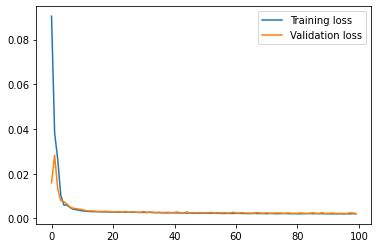

In [67]:
history = model.fit(trainX, trainY, epochs=100, batch_size=128, validation_split=0.2, verbose=1)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [93]:
model = load_model('Modelos_Single_Step\model_lstm_singlestep_nstep7_3feat_s_satur.h5')

In [94]:
x_input = array(testX[0].reshape((1, testX.shape[1], testX.shape[2])))
x_input

array([[[0.02386591, 0.29523707, 0.09764045],
        [0.02096718, 0.29625649, 0.09860007],
        [0.01943819, 0.30129978, 0.10063429],
        [0.03339206, 0.30669705, 0.10425134],
        [0.03241433, 0.31090466, 0.10883558],
        [0.0373558 , 0.31663391, 0.11097574],
        [0.03746988, 0.33445654, 0.11375817]]])

In [95]:
prediction_first = model.predict(x_input)
prediction = model.predict(testX[-testX.shape[0]:])
print(testY[0])
print(prediction_first)

1/1 [==============================] - 0s 26ms/step
[0.03661389]
[[0.03135892]]


In [96]:
prediction_copies = np.repeat(prediction, df_for_testing_scaled.shape[1], axis=-1)
y_pred_future = scaler_minmax.inverse_transform(prediction_copies)[:,0]

C:\Users\pablo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\pablo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Data', ylabel='PLD - SE (R$/MWh)'>

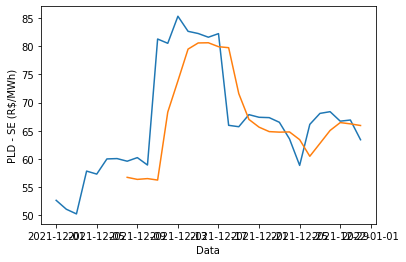

In [97]:
forecast_dates = []
for time_i in df_teste.index[n_past:]:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'PLD predito (R$/Mwh)':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

df = pd.DataFrame({'Data':df_escolhido_2['2021-12-01':].index, 'PLD - SE (R$/MWh)':df_escolhido_2['2021-12-01':]['SE - PLD Médio (R$/MWh)']})

original = df[['Data', 'PLD - SE (R$/MWh)']]

sns.lineplot(original['Data'], original['PLD - SE (R$/MWh)'])
sns.lineplot(df_forecast['Date'], df_forecast['PLD predito (R$/Mwh)'])

In [98]:
original_c = original.set_index(['Data'])
df_forecast_c = df_forecast.set_index(['Date'])
df_comparacao = original_c.join(df_forecast_c)
df_comparacao_clean = df_comparacao.dropna()

In [99]:
av_3feat = avaliacao(df_comparacao_clean, 'PLD predito (R$/Mwh)', 'PLD - SE (R$/MWh)')
print(av_3feat[0])
print(av_3feat[1])
print(av_3feat[2])

4.831921852959529
0.06700413714964844
7.335786538343771


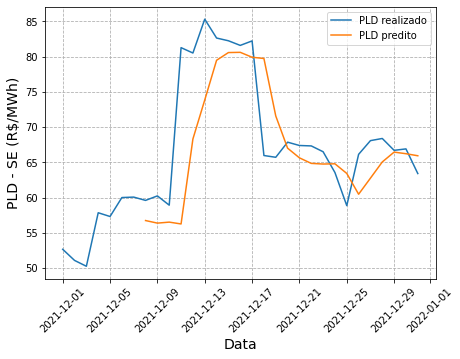

In [100]:
df_comparacao_plot = df_comparacao
plt.figure(figsize=(7, 5)) # REGULAR O TAMANHO AQUI
plt.plot(df_comparacao_plot['PLD - SE (R$/MWh)'], label = 'PLD realizado')
plt.plot(df_comparacao_plot['PLD predito (R$/Mwh)'], label = 'PLD predito')
plt.legend()
plt.xticks(rotation=45)
plt.xlabel('Data', fontsize=14)
plt.ylabel('PLD - SE (R$/MWh)', fontsize=14)
plt.grid(linestyle='--') # Para colocar o grid
#plt.title('Comparação entre PLD realizado e predito', fontsize=16) # Titulo
plt.show()
#plt.savefig(r'C:\Users\pablo\OneDrive\Pictures\AAA TCC\Single_step\Passo1_s_saturacao',bbox_inches='tight')

___________________________________________________________________________________________________________________________

# Single Step 1 forward

In [101]:
iniciotrein, fimtrein, inicioteste, fimteste = '2018-02-05','2021-11-30','2021-12-01','2021-12-31'
df_treinamento = df_3_features.loc[iniciotrein:fimtrein]
df_teste = df_3_features.loc[inicioteste:fimteste]

df_for_training = df_treinamento
scaler = MinMaxScaler(feature_range=(0, 1))
scaler_train = scaler.fit(df_for_training)
df_for_training_scaled = scaler_train.transform(df_for_training)
df_comp_trein = pd.DataFrame(df_for_training_scaled)
df_comp_trein = df_comp_trein.rename(columns={0:'SE - PLD Médio (R$/MWh)',1:'ENA Bruta (MWm)',2:'EAR Verif. (MWmês)'})
df_comp_trein = df_comp_trein.set_index(df_treinamento.index)



df_for_testing = df_teste
#scaler = StandardScaler()
#scaler_test = scaler.fit(df_for_testing)
df_for_testing_scaled = scaler_train.transform(df_for_testing)
df_comp_teste = pd.DataFrame(df_for_testing_scaled)
df_comp_teste = df_comp_teste.rename(columns={0:'SE - PLD Médio (R$/MWh)',1:'ENA Bruta (MWm)',2:'EAR Verif. (MWmês)'})
df_comp_teste = df_comp_teste.set_index(df_teste.index)


In [102]:
n_future = 1 
n_past = 7

trainX = []
trainY = []
train_dates = df_treinamento.index
testX = []
testY = []
test_dates = df_teste.index
test_dates

DatetimeIndex(['2021-12-01', '2021-12-02', '2021-12-03', '2021-12-04',
               '2021-12-05', '2021-12-06', '2021-12-07', '2021-12-08',
               '2021-12-09', '2021-12-10', '2021-12-11', '2021-12-12',
               '2021-12-13', '2021-12-14', '2021-12-15', '2021-12-16',
               '2021-12-17', '2021-12-18', '2021-12-19', '2021-12-20',
               '2021-12-21', '2021-12-22', '2021-12-23', '2021-12-24',
               '2021-12-25', '2021-12-26', '2021-12-27', '2021-12-28',
               '2021-12-29', '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='Data', freq=None)

In [103]:
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])
    
trainX, trainY = np.array(trainX), np.array(trainY)

In [104]:
for i in range(n_past, len(df_for_testing_scaled) - n_future +1):
    testX.append(df_for_testing_scaled[i - n_past:i, 0:df_for_testing.shape[1]])
    testY.append(df_for_testing_scaled[i + n_future - 1:i + n_future, 0])
    
testX, testY = np.array(testX), np.array(testY)

In [105]:
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))
print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

trainX shape == (1302, 7, 3).
trainY shape == (1302, 1).
testX shape == (24, 7, 3).
testY shape == (24, 1).


In [107]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(100, activation='relu'))
model.add(Dense(trainY.shape[1]))
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               41600     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 51,801
Trainable params: 51,801
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
9/9 [==============================] - 2s 46ms/step - loss: 0.1513 - val_loss: 0.1492
Epoch 2/100
9/9 [==============================] - 0s 13ms/step - loss: 0.0544 - val_loss: 0.0270
Epoch 3/100
9/9 [==============================] - 0s 13ms/step - loss: 0.0179 - val_loss: 0.0119
Epoch 4/100
9/9 [==============================] - 0s 12ms/step - loss: 0.0084 - val_loss: 0.0164
Epoch 5/100
9/9 [==============================] - 0s 13ms/step - loss: 0.0076 - val_loss: 0.0074
Epoch 6/100
9/9 [==============================] - 0s 12ms/step - loss: 0.0058 - val_loss: 0.0064
Epoch 7/100
9/9 [==============================] - 0s 14ms/step - loss: 0.0053 - val_loss: 0.0056
Epoch 8/100
9/9 [==============================] - 0s 13ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 9/100
9/9 [==============================] - 0s 13ms/step - loss: 0.0047 - val_loss: 0.0047
Epoch 10/100
9/9 [==============================] - 0s 13ms/step - loss: 0.0045 - val_loss: 0.0047
Epoch 11/100
9/9 [=

Epoch 84/100
9/9 [==============================] - 0s 13ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 85/100
9/9 [==============================] - 0s 14ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 86/100
9/9 [==============================] - 0s 13ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 87/100
9/9 [==============================] - 0s 13ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 88/100
9/9 [==============================] - 0s 14ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 89/100
9/9 [==============================] - 0s 19ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 90/100
9/9 [==============================] - 0s 15ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 91/100
9/9 [==============================] - 0s 16ms/step - loss: 0.0033 - val_loss: 0.0036
Epoch 92/100
9/9 [==============================] - 0s 16ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 93/100
9/9 [==============================] - 0s 15ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 94/1

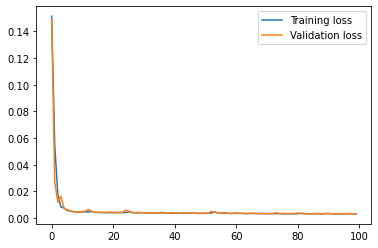

In [108]:
history = model.fit(trainX, trainY, epochs=100, batch_size=128, validation_split=0.2, verbose=1)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [132]:
model = load_model('Modelos_Single_Step\model_lstm_singlestep_nstep7_nforw1_3feat.h5')

In [133]:
x_input = array(testX[0].reshape((1, testX.shape[1], testX.shape[2])))
x_input

array([[[0.02386591, 0.29523707, 0.09764045],
        [0.02096718, 0.29625649, 0.09860007],
        [0.01943819, 0.30129978, 0.10063429],
        [0.03339206, 0.30669705, 0.10425134],
        [0.03241433, 0.31090466, 0.10883558],
        [0.0373558 , 0.31663391, 0.11097574],
        [0.03746988, 0.33445654, 0.11375817]]])

In [134]:
prediction_first = model.predict(x_input)
prediction = model.predict(testX[-testX.shape[0]:])
print(testY[0])
print(prediction_first)

1/1 [==============================] - 0s 21ms/step
[0.03661389]
[[0.0435199]]


In [135]:
prediction_copies = np.repeat(prediction, df_for_testing.shape[1], axis=-1)
y_pred_future = scaler_train.inverse_transform(prediction_copies)[:,0]

In [136]:
np.array(df_teste.index[n_past:])

array(['2021-12-08T00:00:00.000000000', '2021-12-09T00:00:00.000000000',
       '2021-12-10T00:00:00.000000000', '2021-12-11T00:00:00.000000000',
       '2021-12-12T00:00:00.000000000', '2021-12-13T00:00:00.000000000',
       '2021-12-14T00:00:00.000000000', '2021-12-15T00:00:00.000000000',
       '2021-12-16T00:00:00.000000000', '2021-12-17T00:00:00.000000000',
       '2021-12-18T00:00:00.000000000', '2021-12-19T00:00:00.000000000',
       '2021-12-20T00:00:00.000000000', '2021-12-21T00:00:00.000000000',
       '2021-12-22T00:00:00.000000000', '2021-12-23T00:00:00.000000000',
       '2021-12-24T00:00:00.000000000', '2021-12-25T00:00:00.000000000',
       '2021-12-26T00:00:00.000000000', '2021-12-27T00:00:00.000000000',
       '2021-12-28T00:00:00.000000000', '2021-12-29T00:00:00.000000000',
       '2021-12-30T00:00:00.000000000', '2021-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')

C:\Users\pablo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\pablo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Data', ylabel='PLD - SE (R$/MWh)'>

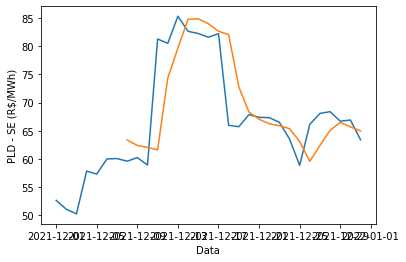

In [137]:
forecast_dates = []
for time_i in df_teste.index[n_past:]:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'PLD predito (R$/Mwh)':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

df = pd.DataFrame({'Data':df_escolhido_2['2021-12-01':].index, 'PLD - SE (R$/MWh)':df_escolhido_2['2021-12-01':]['SE - PLD Médio (R$/MWh)']})

original = df[['Data', 'PLD - SE (R$/MWh)']]

sns.lineplot(original['Data'], original['PLD - SE (R$/MWh)'])
sns.lineplot(df_forecast['Date'], df_forecast['PLD predito (R$/Mwh)'])

In [138]:
original_c = original.set_index(['Data'])
df_forecast_c = df_forecast.set_index(['Date'])
df_comparacao = original_c.join(df_forecast_c)
df_comparacao_clean = df_comparacao.dropna()

In [139]:
av_1 = avaliacao(df_comparacao_clean, 'PLD predito (R$/Mwh)', 'PLD - SE (R$/MWh)')
print(av_1[0])
print(av_1[1])
print(av_1[2])

4.0977967792087115
0.058130766416037954
6.205520151233421


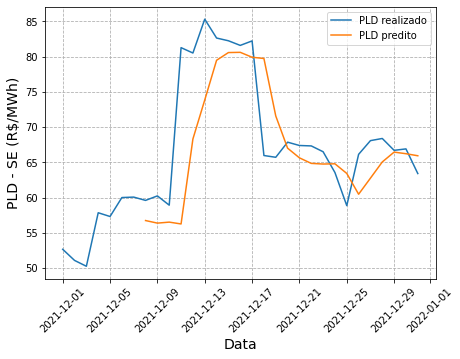

In [140]:
plt.figure(figsize=(7, 5)) # REGULAR O TAMANHO AQUI
plt.plot(df_comparacao_plot['PLD - SE (R$/MWh)'], label = 'PLD realizado')
plt.plot(df_comparacao_plot['PLD predito (R$/Mwh)'], label = 'PLD predito')
plt.legend()
plt.xticks(rotation=45)
plt.xlabel('Data', fontsize=14)
plt.ylabel('PLD - SE (R$/MWh)', fontsize=14)
plt.grid(linestyle='--') # Para colocar o grid
#plt.title('Comparação entre PLD realizado e predito', fontsize=16) # Titulo
#plt.show()
#plt.savefig(r'C:\Users\pablo\OneDrive\Pictures\AAA TCC\Single_step\Passo1_3feature',bbox_inches='tight')

________________________________________________________________________________________________________________________________

# Single Step 2 forward

In [143]:
iniciotrein, fimtrein, inicioteste, fimteste = '2018-02-05','2021-11-30','2021-12-01','2021-12-31'
df_treinamento = df_3_features.loc[iniciotrein:fimtrein]
df_teste = df_3_features.loc[inicioteste:fimteste]

df_for_training = df_treinamento
scaler = MinMaxScaler()
scaler_train = scaler.fit(df_for_training)
df_for_training_scaled = scaler_train.transform(df_for_training)
df_comp_trein = pd.DataFrame(df_for_training_scaled)
df_comp_trein = df_comp_trein.rename(columns={0:'SE - PLD Médio (R$/MWh)',1:'ENA Bruta (MWm)',2:'EAR Verif. (MWmês)'})
df_comp_trein = df_comp_trein.set_index(df_treinamento.index)


In [144]:
df_for_testing = df_teste

df_for_testing_scaled = scaler_train.transform(df_for_testing)
df_comp_teste = pd.DataFrame(df_for_testing_scaled)
df_comp_teste = df_comp_teste.rename(columns={0:'SE - PLD Médio (R$/MWh)',1:'ENA Bruta (MWm)',2:'EAR Verif. (MWmês)'})
df_comp_teste = df_comp_teste.set_index(df_teste.index)


## t+2 a frente


In [145]:
n = 2
n_future = 1 
n_past = 7

In [146]:
testX = []
testY = []
trainX = []
trainY = []

In [147]:
for i in range(n_past, len(df_for_training_scaled) - n_future -n+2):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future +(n-1)-1 :i + n_future+(n-1), 0])
    
trainX, trainY = np.array(trainX), np.array(trainY)

In [148]:
for i in range(n_past, len(df_for_testing_scaled) - n_future -n+2):
    testX.append(df_for_testing_scaled[i - n_past:i, 0:df_for_testing.shape[1]])
    testY.append(df_for_testing_scaled[i + n_future +(n-1)-1 :i + n_future+(n-1), 0])
    
testX, testY = np.array(testX), np.array(testY)

In [149]:
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))
print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

trainX shape == (1301, 7, 3).
trainY shape == (1301, 1).
testX shape == (23, 7, 3).
testY shape == (23, 1).


In [165]:
model = load_model('Modelos_Single_Step\model_lstm_singlestep_nstep7_nforw2_3feat.h5') 

In [166]:
#Make prediction
prediction = model.predict(testX[-testX.shape[0]:]) #shape = (n, 1) where n is the n_days_for_prediction

1/1 [==============================] - 0s 171ms/step


In [167]:
x_input = array(testX[0].reshape((1, testX.shape[1], testX.shape[2])))
x_input

array([[[0.02386591, 0.29523707, 0.09764045],
        [0.02096718, 0.29625649, 0.09860007],
        [0.01943819, 0.30129978, 0.10063429],
        [0.03339206, 0.30669705, 0.10425134],
        [0.03241433, 0.31090466, 0.10883558],
        [0.0373558 , 0.31663391, 0.11097574],
        [0.03746988, 0.33445654, 0.11375817]]])

In [168]:
predction = model.predict(x_input)
predction

1/1 [==============================] - 0s 16ms/step


array([[0.03831343]], dtype=float32)

In [169]:
prediction_copies = np.repeat(prediction, df_for_testing.shape[1], axis=-1)
y_pred_future = scaler_train.inverse_transform(prediction_copies)[:,0]

C:\Users\pablo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\pablo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Data', ylabel='PLD - SE'>

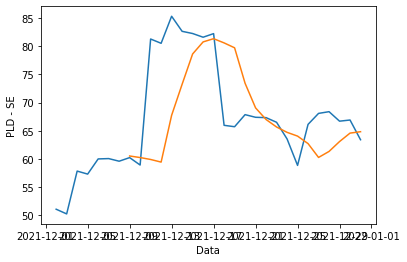

In [170]:
forecast_dates = []
for time_i in df_teste.index[n_past+n-1:]:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'PLD predito':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

df = pd.DataFrame({'Data':df_escolhido_2[-30:].index, 'PLD - SE':df_escolhido_2[-30:]['SE - PLD Médio (R$/MWh)']})

original = df[['Data', 'PLD - SE']]

sns.lineplot(original['Data'], original['PLD - SE'])
sns.lineplot(df_forecast['Date'], df_forecast['PLD predito'])

In [171]:
original_c = original.set_index(['Data'])
df_forecast_c = df_forecast.set_index(['Date'])
df_comparacao = original_c.join(df_forecast_c)
df_comparacao_clean = df_comparacao.dropna()

In [172]:
av_2 = avaliacao(df_comparacao_clean, 'PLD predito', 'PLD - SE')
print(av_2[0])
print(av_2[1])
print(av_2[2])

6.320554800724636
0.08620591912245648
9.157839328370242


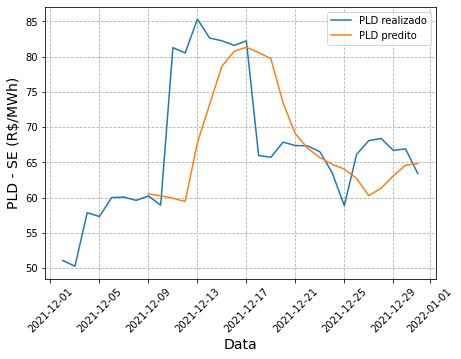

In [173]:
df_comparacao_plot = df_comparacao
plt.figure(figsize=(7, 5)) # REGULAR O TAMANHO AQUI
plt.plot(df_comparacao_plot['PLD - SE'], label = 'PLD realizado')
plt.plot(df_comparacao_plot['PLD predito'], label = 'PLD predito')
plt.legend()
plt.xticks(rotation=45)
plt.xlabel('Data', fontsize=14)
plt.ylabel('PLD - SE (R$/MWh)', fontsize=14)
plt.grid(linestyle='--') # Para colocar o grid
#plt.title('Comparação entre PLD realizado e predito', fontsize=16) # Titulo
plt.show()
#plt.savefig(r'C:\Users\pablo\OneDrive\Pictures\AAA TCC\Single_step\Passo2_singlestep',bbox_inches='tight')

________________________________________________________________________________________________________________________________________

# Single Step 3 forward

In [175]:
iniciotrein, fimtrein, inicioteste, fimteste = '2018-02-05','2021-11-30','2021-12-01','2021-12-31'
df_treinamento = df_3_features.loc[iniciotrein:fimtrein]
df_teste = df_3_features.loc[inicioteste:fimteste]

df_for_training = df_treinamento
scaler = MinMaxScaler()
scaler_train = scaler.fit(df_for_training)
df_for_training_scaled = scaler_train.transform(df_for_training)
df_comp_trein = pd.DataFrame(df_for_training_scaled)
df_comp_trein = df_comp_trein.rename(columns={0:'SE - PLD Médio (R$/MWh)',1:'ENA Bruta (MWm)',2:'EAR Verif. (MWmês)'})
df_comp_trein = df_comp_trein.set_index(df_treinamento.index)
df_comp_trein

,SE - PLD Médio (R$/MWh),ENA Bruta (MWm),EAR Verif. (MWmês)
Data,,,
2018-05-02,0.321509,0.363627,0.607552
2018-05-03,0.237459,0.350607,0.605189
2018-05-04,0.341170,0.343412,0.602083
2018-05-05,0.433390,0.335991,0.600872
2018-05-06,0.212521,0.328326,0.600365
...,...,...,...
2021-11-26,0.102829,0.287977,0.093900
2021-11-27,0.018552,0.283624,0.095486
2021-11-28,0.018555,0.285572,0.097611


In [176]:
df_for_testing = df_teste
df_for_testing_scaled = scaler_train.transform(df_for_testing)
df_comp_teste = pd.DataFrame(df_for_testing_scaled)
df_comp_teste = df_comp_teste.rename(columns={0:'SE - PLD Médio (R$/MWh)',1:'ENA Bruta (MWm)',2:'EAR Verif. (MWmês)'})
df_comp_teste = df_comp_teste.set_index(df_teste.index)
df_comp_teste

,SE - PLD Médio (R$/MWh),ENA Bruta (MWm),EAR Verif. (MWmês)
Data,,,
2021-12-01,0.023866,0.295237,0.097640
2021-12-02,0.020967,0.296256,0.098600
2021-12-03,0.019438,0.301300,0.100634
2021-12-04,0.033392,0.306697,0.104251
2021-12-05,0.032414,0.310905,0.108836
2021-12-06,0.037356,0.316634,0.110976
2021-12-07,0.037470,0.334457,0.113758
2021-12-08,0.036614,0.353977,0.118007
2021-12-09,0.037786,0.368935,0.120720


## t+3 a frente


In [177]:
n = 3
n_future = 1 
n_past = 7

In [178]:
testX = []
testY = []
trainX = []
trainY = []

In [179]:
for i in range(n_past, len(df_for_training_scaled) - n_future -n+2):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future +(n-1)-1 :i + n_future+(n-1), 0])
    
trainX, trainY = np.array(trainX), np.array(trainY)

In [180]:
for i in range(n_past, len(df_for_testing_scaled) - n_future -n+2):
    testX.append(df_for_testing_scaled[i - n_past:i, 0:df_for_testing.shape[1]])
    testY.append(df_for_testing_scaled[i + n_future +(n-1)-1 :i + n_future+(n-1), 0])
    
testX, testY = np.array(testX), np.array(testY)

In [181]:
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))
print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

trainX shape == (1300, 7, 3).
trainY shape == (1300, 1).
testX shape == (22, 7, 3).
testY shape == (22, 1).


In [182]:
model = load_model('Modelos_Single_Step\model_lstm_singlestep_nstep7_nforw3_3feat.h5')

In [183]:
prediction = model.predict(testX[-testX.shape[0]:]) #shape = (n, 1) where n is the n_days_for_prediction

1/1 [==============================] - 0s 219ms/step


In [184]:
x_input = array(testX[0].reshape((1, testX.shape[1], testX.shape[2])))
x_input

array([[[0.02386591, 0.29523707, 0.09764045],
        [0.02096718, 0.29625649, 0.09860007],
        [0.01943819, 0.30129978, 0.10063429],
        [0.03339206, 0.30669705, 0.10425134],
        [0.03241433, 0.31090466, 0.10883558],
        [0.0373558 , 0.31663391, 0.11097574],
        [0.03746988, 0.33445654, 0.11375817]]])

In [185]:
predction = model.predict(x_input)
predction

1/1 [==============================] - 0s 19ms/step


array([[0.05109695]], dtype=float32)

In [186]:
prediction_copies = np.repeat(prediction, df_for_testing.shape[1], axis=-1)
y_pred_future = scaler_train.inverse_transform(prediction_copies)[:,0]

C:\Users\pablo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\pablo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Data', ylabel='PLD - SE'>

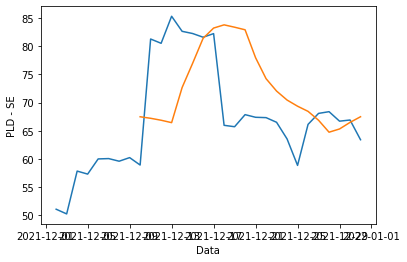

In [187]:
forecast_dates = []
for time_i in df_teste.index[n_past+n-1:]:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'PLD predito':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

df = pd.DataFrame({'Data':df_escolhido_2[-30:].index, 'PLD - SE':df_escolhido_2[-30:]['SE - PLD Médio (R$/MWh)']})

original = df[['Data', 'PLD - SE']]

sns.lineplot(original['Data'], original['PLD - SE'])
sns.lineplot(df_forecast['Date'], df_forecast['PLD predito'])

In [188]:
original_c = original.set_index(['Data'])
df_forecast_c = df_forecast.set_index(['Date'])
df_comparacao = original_c.join(df_forecast_c)
df_comparacao_clean = df_comparacao.dropna()

In [189]:
av_3 = avaliacao(df_comparacao_clean, 'PLD predito', 'PLD - SE')
print(av_3[0])
print(av_3[1])
print(av_3[2])

7.9788259517785285
0.11342360130998554
9.962480493827865


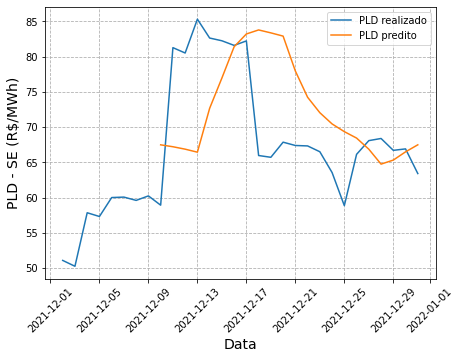

In [190]:
df_comparacao_plot = df_comparacao
plt.figure(figsize=(7, 5)) # REGULAR O TAMANHO AQUI
plt.plot(df_comparacao_plot['PLD - SE'], label = 'PLD realizado')
plt.plot(df_comparacao_plot['PLD predito'], label = 'PLD predito')
plt.legend()
plt.xticks(rotation=45)
plt.xlabel('Data', fontsize=14)
plt.ylabel('PLD - SE (R$/MWh)', fontsize=14)
plt.grid(linestyle='--') # Para colocar o grid
#plt.title('Comparação entre PLD realizado e predito', fontsize=16) # Titulo
plt.show()
#plt.savefig(r'C:\Users\pablo\OneDrive\Pictures\AAA TCC\Single_step\Passo3_singlestep',bbox_inches='tight')

________________________________________________________________________________________________________________________________________

# Single Step 4 forward

In [191]:
iniciotrein, fimtrein, inicioteste, fimteste = '2018-02-05','2021-11-30','2021-12-01','2021-12-31'
df_treinamento = df_3_features.loc[iniciotrein:fimtrein]
df_teste = df_3_features.loc[inicioteste:fimteste]

df_for_training = df_treinamento
scaler = MinMaxScaler()
scaler_train = scaler.fit(df_for_training)
df_for_training_scaled = scaler_train.transform(df_for_training)
df_comp_trein = pd.DataFrame(df_for_training_scaled)
df_comp_trein = df_comp_trein.rename(columns={0:'SE - PLD Médio (R$/MWh)',1:'ENA Bruta (MWm)',2:'EAR Verif. (MWmês)'})
df_comp_trein = df_comp_trein.set_index(df_treinamento.index)

In [193]:
df_for_testing = df_teste
df_for_testing_scaled = scaler_train.transform(df_for_testing)
df_comp_teste = pd.DataFrame(df_for_testing_scaled)
df_comp_teste = df_comp_teste.rename(columns={0:'SE - PLD Médio (R$/MWh)',1:'ENA Bruta (MWm)',2:'EAR Verif. (MWmês)'})
df_comp_teste = df_comp_teste.set_index(df_teste.index)

## t+4 a frente


In [194]:
n = 4
n_future = 1 
n_past = 7

In [195]:
testX = []
testY = []
trainX = []
trainY = []

In [196]:
for i in range(n_past, len(df_for_training_scaled) - n_future -n+2):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future +(n-1)-1 :i + n_future+(n-1), 0])
    
trainX, trainY = np.array(trainX), np.array(trainY)

In [197]:
for i in range(n_past, len(df_for_testing_scaled) - n_future -n+2):
    testX.append(df_for_testing_scaled[i - n_past:i, 0:df_for_testing.shape[1]])
    testY.append(df_for_testing_scaled[i + n_future +(n-1)-1 :i + n_future+(n-1), 0])
    
testX, testY = np.array(testX), np.array(testY)

In [198]:
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))
print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

trainX shape == (1299, 7, 3).
trainY shape == (1299, 1).
testX shape == (21, 7, 3).
testY shape == (21, 1).


In [199]:
model = load_model('Modelos_Single_Step\model_lstm_singlestep_nstep7_nforw4_3feat.h5')

In [200]:
prediction = model.predict(testX[-testX.shape[0]:]) #shape = (n, 1) where n is the n_days_for_prediction

1/1 [==============================] - 0s 206ms/step


In [201]:
x_input = array(testX[0].reshape((1, testX.shape[1], testX.shape[2])))
x_input

array([[[0.02386591, 0.29523707, 0.09764045],
        [0.02096718, 0.29625649, 0.09860007],
        [0.01943819, 0.30129978, 0.10063429],
        [0.03339206, 0.30669705, 0.10425134],
        [0.03241433, 0.31090466, 0.10883558],
        [0.0373558 , 0.31663391, 0.11097574],
        [0.03746988, 0.33445654, 0.11375817]]])

In [202]:
predction = model.predict(x_input)
predction

1/1 [==============================] - 0s 19ms/step


array([[0.04972646]], dtype=float32)

In [205]:
prediction_copies = np.repeat(prediction, df_for_testing.shape[1], axis=-1)
y_pred_future = scaler_train.inverse_transform(prediction_copies)[:,0]

C:\Users\pablo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\pablo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Data', ylabel='PLD - SE'>

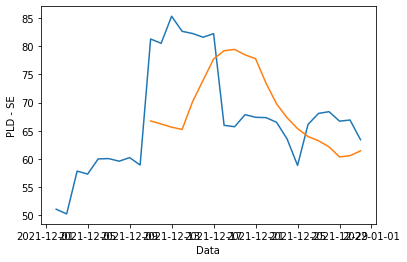

In [206]:
forecast_dates = []
for time_i in df_teste.index[n_past+n-1:]:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'PLD predito':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

df = pd.DataFrame({'Data':df_escolhido_2[-30:].index, 'PLD - SE':df_escolhido_2[-30:]['SE - PLD Médio (R$/MWh)']})

original = df[['Data', 'PLD - SE']]

sns.lineplot(original['Data'], original['PLD - SE'])
sns.lineplot(df_forecast['Date'], df_forecast['PLD predito'])

In [207]:
original_c = original.set_index(['Data'])
df_forecast_c = df_forecast.set_index(['Date'])
df_comparacao = original_c.join(df_forecast_c)
df_comparacao_clean = df_comparacao.dropna()

In [208]:
av_4 = avaliacao(df_comparacao_clean, 'PLD predito', 'PLD - SE')
print(av_4[0])
print(av_4[1])
print(av_4[2])

8.837354559519937
0.12084259446173087
10.163470103570075


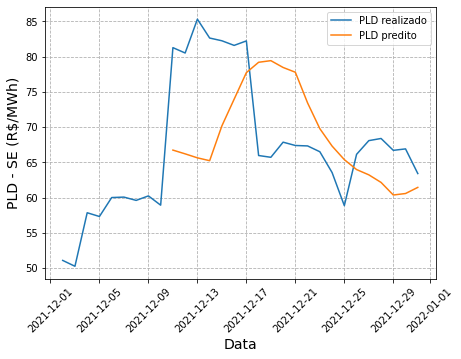

In [209]:
df_comparacao_plot = df_comparacao
plt.figure(figsize=(7, 5)) # REGULAR O TAMANHO AQUI
plt.plot(df_comparacao_plot['PLD - SE'], label = 'PLD realizado')
plt.plot(df_comparacao_plot['PLD predito'], label = 'PLD predito')
plt.legend()
plt.xticks(rotation=45)
plt.xlabel('Data', fontsize=14)
plt.ylabel('PLD - SE (R$/MWh)', fontsize=14)
plt.grid(linestyle='--') # Para colocar o grid
#plt.title('Comparação entre PLD realizado e predito', fontsize=16) # Titulo
plt.show()
#plt.savefig(r'C:\Users\pablo\OneDrive\Pictures\AAA TCC\Single_step\Passo4_singlestep',bbox_inches='tight')

________________________________________________________________________________________________________________________________________

# Single Step 5 forward

In [210]:
iniciotrein, fimtrein, inicioteste, fimteste = '2018-02-05','2021-11-30','2021-12-01','2021-12-31'
df_treinamento = df_3_features.loc[iniciotrein:fimtrein]
df_teste = df_3_features.loc[inicioteste:fimteste]

df_for_training = df_treinamento
scaler = MinMaxScaler()
scaler_train = scaler.fit(df_for_training)
df_for_training_scaled = scaler_train.transform(df_for_training)
df_comp_trein = pd.DataFrame(df_for_training_scaled)
df_comp_trein = df_comp_trein.rename(columns={0:'SE - PLD Médio (R$/MWh)',1:'ENA Bruta (MWm)',2:'EAR Verif. (MWmês)'})
df_comp_trein = df_comp_trein.set_index(df_treinamento.index)

In [211]:
df_for_testing = df_teste
df_for_testing_scaled = scaler_train.transform(df_for_testing)
df_comp_teste = pd.DataFrame(df_for_testing_scaled)
df_comp_teste = df_comp_teste.rename(columns={0:'SE - PLD Médio (R$/MWh)',1:'ENA Bruta (MWm)',2:'EAR Verif. (MWmês)'})
df_comp_teste = df_comp_teste.set_index(df_teste.index)

## t+5 a frente


In [212]:
n = 5
n_future = 1 
n_past = 7

In [213]:
testX = []
testY = []
trainX = []
trainY = []

In [214]:
for i in range(n_past, len(df_for_training_scaled) - n_future -n+2):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future +(n-1)-1 :i + n_future+(n-1), 0])
    
trainX, trainY = np.array(trainX), np.array(trainY)

In [215]:
for i in range(n_past, len(df_for_testing_scaled) - n_future -n+2):
    testX.append(df_for_testing_scaled[i - n_past:i, 0:df_for_testing.shape[1]])
    testY.append(df_for_testing_scaled[i + n_future +(n-1)-1 :i + n_future+(n-1), 0])
    
testX, testY = np.array(testX), np.array(testY)

In [216]:
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))
print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

trainX shape == (1298, 7, 3).
trainY shape == (1298, 1).
testX shape == (20, 7, 3).
testY shape == (20, 1).


In [225]:
model = load_model('Modelos_Single_Step\model_lstm_singlestep_nstep7_nforw5_3feat.h5')

In [226]:
#Make prediction
prediction = model.predict(testX[-testX.shape[0]:]) #shape = (n, 1) where n is the n_days_for_prediction

1/1 [==============================] - 0s 188ms/step


In [227]:
x_input = array(testX[0].reshape((1, testX.shape[1], testX.shape[2])))
x_input

array([[[0.02386591, 0.29523707, 0.09764045],
        [0.02096718, 0.29625649, 0.09860007],
        [0.01943819, 0.30129978, 0.10063429],
        [0.03339206, 0.30669705, 0.10425134],
        [0.03241433, 0.31090466, 0.10883558],
        [0.0373558 , 0.31663391, 0.11097574],
        [0.03746988, 0.33445654, 0.11375817]]])

In [228]:
predction = model.predict(x_input)
predction

1/1 [==============================] - 0s 24ms/step


array([[0.03571129]], dtype=float32)

In [229]:
prediction_copies = np.repeat(prediction, df_for_testing.shape[1], axis=-1)
y_pred_future = scaler_train.inverse_transform(prediction_copies)[:,0]

C:\Users\pablo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\pablo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Data', ylabel='PLD - SE'>

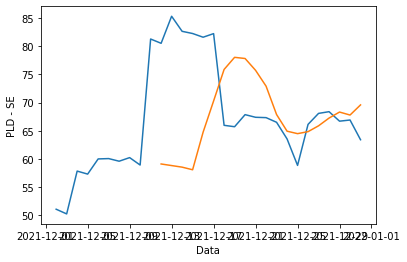

In [230]:
forecast_dates = []
for time_i in df_teste.index[n_past+n-1:]:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'PLD predito':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

df = pd.DataFrame({'Data':df_escolhido_2[-30:].index, 'PLD - SE':df_escolhido_2[-30:]['SE - PLD Médio (R$/MWh)']})

original = df[['Data', 'PLD - SE']]

sns.lineplot(original['Data'], original['PLD - SE'])
sns.lineplot(df_forecast['Date'], df_forecast['PLD predito'])

In [231]:
original_c = original.set_index(['Data'])
df_forecast_c = df_forecast.set_index(['Date'])
df_comparacao = original_c.join(df_forecast_c)
df_comparacao_clean = df_comparacao.dropna()

In [232]:
av_5 = avaliacao(df_comparacao_clean, 'PLD predito', 'PLD - SE')
print(av_5[0])
print(av_5[1])
print(av_5[2])

9.633807378133138
0.12724386384411063
12.813312063323108


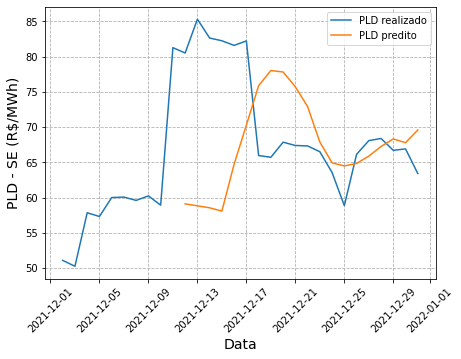

In [233]:
df_comparacao_plot = df_comparacao
plt.figure(figsize=(7, 5)) # REGULAR O TAMANHO AQUI
plt.plot(df_comparacao_plot['PLD - SE'], label = 'PLD realizado')
plt.plot(df_comparacao_plot['PLD predito'], label = 'PLD predito')
plt.legend()
plt.xticks(rotation=45)
plt.xlabel('Data', fontsize=14)
plt.ylabel('PLD - SE (R$/MWh)', fontsize=14)
plt.grid(linestyle='--') # Para colocar o grid
#plt.title('Comparação entre PLD realizado e predito', fontsize=16) # Titulo
plt.show()
#plt.savefig(r'C:\Users\pablo\OneDrive\Pictures\AAA TCC\Single_step\Passo5_singlestep',bbox_inches='tight')

________________________________________________________________________________________________________________________________________

# Single Step 6 forward

In [234]:
iniciotrein, fimtrein, inicioteste, fimteste = '2018-02-05','2021-11-30','2021-12-01','2021-12-31'
df_treinamento = df_3_features.loc[iniciotrein:fimtrein]
df_teste = df_3_features.loc[inicioteste:fimteste]

df_for_training = df_treinamento
scaler = MinMaxScaler()
scaler_train = scaler.fit(df_for_training)
df_for_training_scaled = scaler_train.transform(df_for_training)
df_comp_trein = pd.DataFrame(df_for_training_scaled)
df_comp_trein = df_comp_trein.rename(columns={0:'SE - PLD Médio (R$/MWh)',1:'ENA Bruta (MWm)',2:'EAR Verif. (MWmês)'})
df_comp_trein = df_comp_trein.set_index(df_treinamento.index)

In [235]:
df_for_testing = df_teste
df_for_testing_scaled = scaler_train.transform(df_for_testing)
df_comp_teste = pd.DataFrame(df_for_testing_scaled)
df_comp_teste = df_comp_teste.rename(columns={0:'SE - PLD Médio (R$/MWh)',1:'ENA Bruta (MWm)',2:'EAR Verif. (MWmês)'})
df_comp_teste = df_comp_teste.set_index(df_teste.index)

## t+6 a frente


In [236]:
n = 6
n_future = 1 
n_past = 7

In [237]:
testX = []
testY = []
trainX = []
trainY = []

In [238]:
for i in range(n_past, len(df_for_training_scaled) - n_future -n+2):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future +(n-1)-1 :i + n_future+(n-1), 0])
    
trainX, trainY = np.array(trainX), np.array(trainY)

In [239]:
for i in range(n_past, len(df_for_testing_scaled) - n_future -n+2):
    testX.append(df_for_testing_scaled[i - n_past:i, 0:df_for_testing.shape[1]])
    testY.append(df_for_testing_scaled[i + n_future +(n-1)-1 :i + n_future+(n-1), 0])
    
testX, testY = np.array(testX), np.array(testY)

In [240]:
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))
print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

trainX shape == (1297, 7, 3).
trainY shape == (1297, 1).
testX shape == (19, 7, 3).
testY shape == (19, 1).


In [241]:
model = load_model('Modelos_Single_Step\model_lstm_singlestep_nstep7_nforw6_3feat.h5')

In [242]:
prediction = model.predict(testX[-testX.shape[0]:]) #shape = (n, 1) where n is the n_days_for_prediction

1/1 [==============================] - 0s 218ms/step


In [243]:
x_input = array(testX[0].reshape((1, testX.shape[1], testX.shape[2])))
x_input

array([[[0.02386591, 0.29523707, 0.09764045],
        [0.02096718, 0.29625649, 0.09860007],
        [0.01943819, 0.30129978, 0.10063429],
        [0.03339206, 0.30669705, 0.10425134],
        [0.03241433, 0.31090466, 0.10883558],
        [0.0373558 , 0.31663391, 0.11097574],
        [0.03746988, 0.33445654, 0.11375817]]])

In [244]:
predction = model.predict(x_input)
predction

1/1 [==============================] - 0s 18ms/step


array([[0.03564835]], dtype=float32)

In [245]:
prediction_copies = np.repeat(prediction, df_for_testing.shape[1], axis=-1)
y_pred_future = scaler_train.inverse_transform(prediction_copies)[:,0]

C:\Users\pablo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\pablo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Data', ylabel='PLD - SE'>

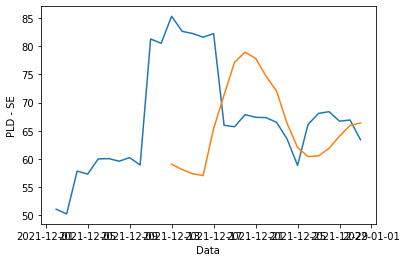

In [246]:
forecast_dates = []
for time_i in df_teste.index[n_past+n-1:]:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'PLD predito':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

df = pd.DataFrame({'Data':df_escolhido_2[-30:].index, 'PLD - SE':df_escolhido_2[-30:]['SE - PLD Médio (R$/MWh)']})

original = df[['Data', 'PLD - SE']]

sns.lineplot(original['Data'], original['PLD - SE'])
sns.lineplot(df_forecast['Date'], df_forecast['PLD predito'])

In [247]:
original_c = original.set_index(['Data'])
df_forecast_c = df_forecast.set_index(['Date'])
df_comparacao = original_c.join(df_forecast_c)
df_comparacao_clean = df_comparacao.dropna()

In [248]:
av_6 = avaliacao(df_comparacao_clean, 'PLD predito', 'PLD - SE')
print(av_6[0])
print(av_6[1])
print(av_6[2])

10.554401804606123
0.14049042264665254
13.448950066105587


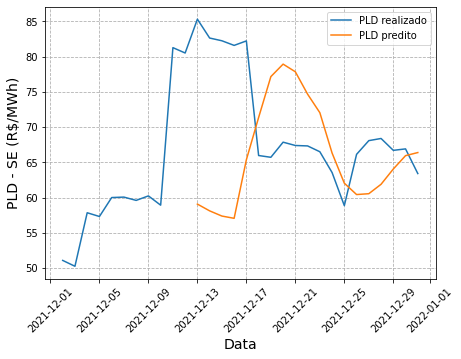

In [249]:
df_comparacao_plot = df_comparacao
plt.figure(figsize=(7, 5)) # REGULAR O TAMANHO AQUI
plt.plot(df_comparacao_plot['PLD - SE'], label = 'PLD realizado')
plt.plot(df_comparacao_plot['PLD predito'], label = 'PLD predito')
plt.legend()
plt.xticks(rotation=45)
plt.xlabel('Data', fontsize=14)
plt.ylabel('PLD - SE (R$/MWh)', fontsize=14)
plt.grid(linestyle='--') # Para colocar o grid
#plt.title('Comparação entre PLD realizado e predito', fontsize=16) # Titulo
plt.show()
#plt.savefig(r'C:\Users\pablo\OneDrive\Pictures\AAA TCC\Single_step\Passo6_singlestep',bbox_inches='tight')

________________________________________________________________________________________________________________________________________

# Single Step 7 forward

In [253]:
iniciotrein, fimtrein, inicioteste, fimteste = '2018-02-05','2021-11-30','2021-12-01','2021-12-31'
df_treinamento = df_3_features.loc[iniciotrein:fimtrein]
df_teste = df_3_features.loc[inicioteste:fimteste]

df_for_training = df_treinamento
scaler = MinMaxScaler()
scaler_train = scaler.fit(df_for_training)
df_for_training_scaled = scaler_train.transform(df_for_training)
df_comp_trein = pd.DataFrame(df_for_training_scaled)
df_comp_trein = df_comp_trein.rename(columns={0:'SE - PLD Médio (R$/MWh)',1:'ENA Bruta (MWm)',2:'EAR Verif. (MWmês)'})
df_comp_trein = df_comp_trein.set_index(df_treinamento.index)


In [254]:
df_for_testing = df_teste
df_for_testing_scaled = scaler_train.transform(df_for_testing)
df_comp_teste = pd.DataFrame(df_for_testing_scaled)
df_comp_teste = df_comp_teste.rename(columns={0:'SE - PLD Médio (R$/MWh)',1:'ENA Bruta (MWm)',2:'EAR Verif. (MWmês)'})
df_comp_teste = df_comp_teste.set_index(df_teste.index)


## t+7 a frente


In [255]:
n = 7
n_future = 1 
n_past = 7

In [256]:
testX = []
testY = []
trainX = []
trainY = []

In [257]:
for i in range(n_past, len(df_for_training_scaled) - n_future -n+2):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future +(n-1)-1 :i + n_future+(n-1), 0])
    
trainX, trainY = np.array(trainX), np.array(trainY)

In [258]:
for i in range(n_past, len(df_for_testing_scaled) - n_future -n+2):
    testX.append(df_for_testing_scaled[i - n_past:i, 0:df_for_testing.shape[1]])
    testY.append(df_for_testing_scaled[i + n_future +(n-1)-1 :i + n_future+(n-1), 0])
    
testX, testY = np.array(testX), np.array(testY)

In [259]:
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))
print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

trainX shape == (1296, 7, 3).
trainY shape == (1296, 1).
testX shape == (18, 7, 3).
testY shape == (18, 1).


In [260]:
model = load_model('Modelos_Single_Step\model_lstm_singlestep_nstep7_nforw7_3feat.h5')

In [261]:
prediction = model.predict(testX[-testX.shape[0]:]) #shape = (n, 1) where n is the n_days_for_prediction

1/1 [==============================] - 0s 193ms/step


In [262]:
x_input = array(testX[0].reshape((1, testX.shape[1], testX.shape[2])))
x_input

array([[[0.02386591, 0.29523707, 0.09764045],
        [0.02096718, 0.29625649, 0.09860007],
        [0.01943819, 0.30129978, 0.10063429],
        [0.03339206, 0.30669705, 0.10425134],
        [0.03241433, 0.31090466, 0.10883558],
        [0.0373558 , 0.31663391, 0.11097574],
        [0.03746988, 0.33445654, 0.11375817]]])

In [263]:
predction = model.predict(x_input)
predction

1/1 [==============================] - 0s 19ms/step


array([[0.04517863]], dtype=float32)

In [264]:
prediction_copies = np.repeat(prediction, df_for_testing.shape[1], axis=-1)
y_pred_future = scaler_train.inverse_transform(prediction_copies)[:,0]

C:\Users\pablo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\pablo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Data', ylabel='PLD - SE'>

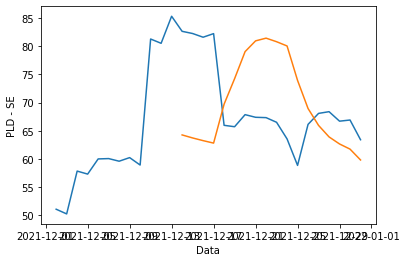

In [265]:
forecast_dates = []
for time_i in df_teste.index[n_past+n-1:]:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'PLD predito':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

df = pd.DataFrame({'Data':df_escolhido_2[-30:].index, 'PLD - SE':df_escolhido_2[-30:]['SE - PLD Médio (R$/MWh)']})

original = df[['Data', 'PLD - SE']]

sns.lineplot(original['Data'], original['PLD - SE'])
sns.lineplot(df_forecast['Date'], df_forecast['PLD predito'])

In [266]:
original_c = original.set_index(['Data'])
df_forecast_c = df_forecast.set_index(['Date'])
df_comparacao = original_c.join(df_forecast_c)
df_comparacao_clean = df_comparacao.dropna()

In [267]:
av_7 = avaliacao(df_comparacao_clean, 'PLD predito', 'PLD - SE')
print(av_7[0])
print(av_7[1])
print(av_7[2])

10.766254425048826
0.15187465742821643
12.425619780693072


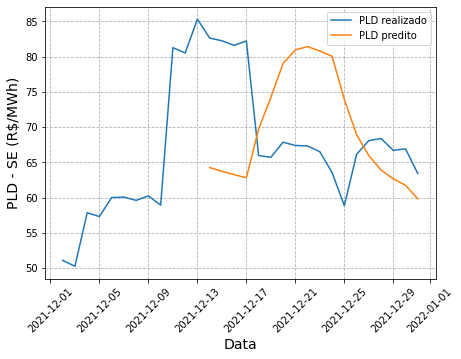

In [268]:
df_comparacao_plot = df_comparacao
plt.figure(figsize=(7, 5)) # REGULAR O TAMANHO AQUI
plt.plot(df_comparacao_plot['PLD - SE'], label = 'PLD realizado')
plt.plot(df_comparacao_plot['PLD predito'], label = 'PLD predito')
plt.legend()
plt.xticks(rotation=45)
plt.xlabel('Data', fontsize=14)
plt.ylabel('PLD - SE (R$/MWh)', fontsize=14)
plt.grid(linestyle='--') # Para colocar o grid
#plt.title('Comparação entre PLD realizado e predito', fontsize=16) # Titulo
#plt.show()
#plt.savefig(r'C:\Users\pablo\OneDrive\Pictures\AAA TCC\Single_step\Passo7_singlestep',bbox_inches='tight')

________________________________________________________________________________________________________________________________________

# União predições modelos

In [269]:
df_res_1 = av_1[3]
df_res_2 = av_2[3]
df_res_3 = av_3[3]
df_res_4 = av_4[3]
df_res_5 = av_5[3]
df_res_6 = av_6[3]
df_res_7 = av_7[3]

In [270]:
df_res_1 = df_res_1.rename(columns={'PLD predito (R$/Mwh)':'PLD predito (R$/Mwh) 1'}).drop(columns={'PE','AE','SE'})
df_res_2 = df_res_2.rename(columns={'PLD predito':'PLD predito (R$/Mwh) 2'}).drop(columns={'PLD - SE','PE','AE','SE'})
df_res_3 = df_res_3.rename(columns={'PLD predito':'PLD predito (R$/Mwh) 3'}).drop(columns={'PLD - SE','PE','AE','SE'})
df_res_4 = df_res_4.rename(columns={'PLD predito':'PLD predito (R$/Mwh) 4'}).drop(columns={'PLD - SE','PE','AE','SE'})
df_res_5 = df_res_5.rename(columns={'PLD predito':'PLD predito (R$/Mwh) 5'}).drop(columns={'PLD - SE','PE','AE','SE'})
df_res_6 = df_res_6.rename(columns={'PLD predito':'PLD predito (R$/Mwh) 6'}).drop(columns={'PLD - SE','PE','AE','SE'})
df_res_7 = df_res_7.rename(columns={'PLD predito':'PLD predito (R$/Mwh) 7'}).drop(columns={'PLD - SE','PE','AE','SE'})

In [271]:
df_res_total = df_res_1.join(df_res_2).join(df_res_3).join(df_res_4).join(df_res_5).join(df_res_6).join(df_res_7)
df_final_modi =  df_res_total.reset_index()

In [272]:
res = pd.DataFrame()
for i in list(range(0,18)):
    res[i] = [df_final_modi.iloc[i][2],df_final_modi.iloc[i+1][3],df_final_modi.iloc[i+2][4],df_final_modi.iloc[i+3][5],df_final_modi.iloc[i+4][6],df_final_modi.iloc[i+5][7],df_final_modi.iloc[i+6][8]]

In [274]:
df_final = pd.DataFrame()
df_final['PLD - SE (R$/MWh)'] =df_res_total['PLD - SE (R$/MWh)']
for i in list(range(0,18)):
    df_aux = pd.DataFrame()
    df_aux[i] = res[i]
    df_aux = df_aux.set_index(df_final_modi['Data'][i:i+7]).rename(columns={i:'PLD predito '+str(i+1)})
    df_final = df_final.join(df_aux)

In [275]:
df_ori = pd.DataFrame()
df_ori['PLD realizado'] =  df_3_features['SE - PLD Médio (R$/MWh)']['2021-12-01':]
df_final = df_ori.join(df_final)


## Plot união

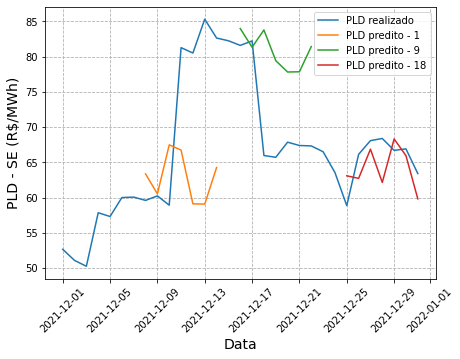

In [276]:
df_comparacao_plot = df_final
plt.figure(figsize=(7, 5)) # REGULAR O TAMANHO AQUI
plt.plot(df_comparacao_plot['PLD realizado'], label = 'PLD realizado')
plt.plot(df_comparacao_plot['PLD predito 1'], label = 'PLD predito - 1')
plt.plot(df_comparacao_plot['PLD predito 9'], label = 'PLD predito - 9')
plt.plot(df_comparacao_plot['PLD predito 18'], label = 'PLD predito - 18')
plt.legend()
plt.xticks(rotation=45)
plt.xlabel('Data', fontsize=14)
plt.ylabel('PLD - SE (R$/MWh)', fontsize=14)
plt.grid(linestyle='--') # Para colocar o grid
#plt.title('Comparação entre PLD realizado e predito', fontsize=16) # Titulo
plt.show()
#plt.savefig(r'C:\Users\pablo\OneDrive\Pictures\AAA TCC\Single_step\Uniao_singlestep',bbox_inches='tight')

In [278]:
dict_global = {} 
for i in list(range(0,18)):
    df_1 = pd.DataFrame()
    df_1['PLD predito '+str(i+1)] = df_final['PLD predito '+str(i+1)]
    df_1 = df_1.join(df_final['PLD - SE (R$/MWh)']).dropna()
    aval = avaliacao(df_1, 'PLD predito '+str(i+1), 'PLD - SE (R$/MWh)')
    dict_info = {'mae':aval[0], 'mape':aval[1], 'rmse':aval[2]}
    dict_append = {'df':aval[3], 'info':dict_info }
    dict_global[i+1] = dict_append

In [297]:
indice = []
maes = []
for i in range (1,18):
    indice.append(i)
    maes.append(dict_global[i]['info']['mae'])
df_mae = pd.DataFrame({'Teste':indice,'MAE':maes})
df_mae['MAE'].mean()

9.20695169400768

In [294]:
indice = []
mapes = []
for i in range (1,18):
    indice.append(i)
    mapes.append(dict_global[i]['info']['mape'])
df_mape = pd.DataFrame({'Teste':indice,'MAPE':mapes})
df_mape['MAPE'].mean()

0.1252291585504292

In [300]:
indice = []
rmses = []
for i in range (1,18):
    indice.append(i)
    rmses.append(dict_global[i]['info']['rmse'])
df_rmse = pd.DataFrame({'Teste':indice,'RMSE':rmses})
df_rmse['SE'] = df_rmse['RMSE']*df_rmse['RMSE']
print(sqrt(df_rmse['SE'].mean()))

11.679802441397069


In [291]:
df_init_7 = dict_global[1]['df'].reset_index()
for i in range(8,len(dict_global)+1):
    df_init_7 =  df_init_7.append(dict_global[i]['df'].reset_index())


In [292]:
df_erros_passos_7 = pd.DataFrame()
df_erros_passos_7['PE Passo 1'] = df_init_7['PE'][0]
df_erros_passos_7['AE Passo 1'] = df_init_7['AE'][0]
df_erros_passos_7['SE Passo 1'] = df_init_7['SE'][0]
df_erros_passos_7 = df_erros_passos_7.reset_index().drop(columns=['index'])
for i in range(1,max(df_init_7.index)+1):
    df_erro = pd.DataFrame()
    df_erro['PE Passo ' + str(i+1)] = df_init_7['PE'][i]
    df_erro['AE Passo ' + str(i+1)] = df_init_7['AE'][i]
    df_erro['SE Passo ' + str(i+1)] = df_init_7['SE'][i]
    df_erro = df_erro.reset_index().drop(columns=['index'])
    df_erros_passos_7 = df_erros_passos_7.join(df_erro)


In [290]:
indice=[]
mape=[]
mae=[]
rmse=[]
for i in range(1,max(df_init_7.index)+2):
    indice.append(i)
    mape.append(df_erros_passos_7['PE Passo '+str(i)].mean())
    mae.append(df_erros_passos_7['AE Passo '+str(i)].mean())
    rmse.append(sqrt(df_erros_passos_7['SE Passo '+str(i)].mean()))
df_erros_7 = pd.DataFrame({'Indice':indice, 'MAE - Singlestep':mae, 'MAPE - Singlestep':mape, 'RMSE - Singlestep':rmse})
df_erros_7 = df_erros_7.set_index('Indice')
#df_erros_7.to_excel('erro_passos_single_step.xlsx')
df_erros_7

,MAE - Singlestep,MAPE - Singlestep,RMSE - Singlestep
Indice,,,
1,4.433091,0.062109,6.807031
2,6.841703,0.091865,9.993619
3,9.223188,0.130602,10.933066
4,9.497484,0.128730,10.762966
5,10.312060,0.135238,13.426104
6,10.975336,0.145687,13.799647
7,10.766254,0.151875,12.425620


________________________________________________________________________________________________________________________________________